## Final Task - Regression Model
* **Virtual Internship Experience (VIX) Program batch Oktober 2023**
* **Data Science - Rakamin x Kalbe Nutritionals**

*Created by: Rakaputra*

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pma

from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

#### **Load/Import Dataset**

In [2]:
df_customer = pd.read_csv("../dataset/Case Study - Customer.csv", sep=";")
df_product = pd.read_csv("../dataset/Case Study - Product.csv", sep=";")
df_store = pd.read_csv("../dataset/Case Study - Store.csv", sep=";")
df_transaction = pd.read_csv("../dataset/Case Study - Transaction.csv", sep=";")

In [3]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [4]:
df_customer.sample(5)

,CustomerID,Age,Gender,Marital Status,Income
406,407,53,1,Married,"9,27"
154,155,40,0,Married,"7,17"
346,347,26,1,Single,"3,69"
247,248,36,1,Married,"5,76"
7,8,37,1,Married,"5,49"


In [5]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [6]:
df_product.sample(5)

,ProductID,Product Name,Price
2,P3,Crackers,7500
0,P1,Choco Bar,8800
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
6,P7,Coffee Candy,9400


In [7]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [8]:
df_store.sample(5)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
11,12,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"


In [9]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [10]:
df_transaction.sample(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
3580,TR54141,160,17/09/2022,P4,12000,1,12000,10
3144,TR27017,133,16/08/2022,P1,8800,2,17600,5
3028,TR63136,234,07/08/2022,P4,12000,3,36000,11
2023,TR64532,154,25/05/2022,P10,15000,5,75000,1
2183,TR69565,362,06/06/2022,P8,16000,1,16000,2


#### **Data Cleaning & Preprocessing**
* Pengisian nilai kosong pada data Customer

In [11]:
list(df_customer["Marital Status"].unique())

['Married', nan, 'Single']

In [12]:
df_customer[df_customer["Marital Status"].isna()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [13]:
df_customer.loc[df_customer["Age"] < 30, "Marital Status"].mode()

0    Single
Name: Marital Status, dtype: object

In [14]:
df_customer.loc[df_customer["Age"] >= 30, "Marital Status"].mode()

0    Married
Name: Marital Status, dtype: object

In [15]:
df_customer.loc[
    df_customer["Marital Status"].isna(), "Marital Status"
] = np.where(df_customer[df_customer["Marital Status"].isna()]["Age"] >= 30,
             "Married", "Single")

df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  447 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


Transformasi data "Income" pada dataset "Customer" dan "Date" pada dataset "Transaction"

In [16]:
df_customer["Income"] = df_customer["Income"].map(lambda x: float(x.replace(",", ".")))
df_transaction["Date"] = pd.to_datetime(df_transaction["Date"], format="%d/%m/%Y")

In [17]:
df_customer.sample(5)

,CustomerID,Age,Gender,Marital Status,Income
239,240,22,1,Single,3.33
157,158,49,1,Married,5.60
280,281,35,0,Married,3.03
89,90,21,1,Single,0.00
438,439,35,0,Single,12.34


In [18]:
df_transaction.sample(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1491,TR95986,425,2022-04-16,P10,15000,3,45000,12
2019,TR41627,430,2022-05-25,P4,12000,4,48000,6
4967,TR26573,9,2022-12-28,P1,8800,5,44000,14
1729,TR98177,92,2022-05-04,P8,16000,2,32000,1
1285,TR62348,62,2022-03-31,P2,3200,5,16000,6


#### **Merge into single Dataframe**

In [19]:
df_merge = pd.merge(df_transaction, df_customer, on="CustomerID")
df_merge = pd.merge(df_merge, df_product, on="ProductID")
df_merge = pd.merge(df_merge, df_store, on="StoreID")
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  Product Name    5020 non-null   object        
 13  Price_y         5020 non-null   int64         
 14  StoreName       5020 non-null   object        
 15  Grou

In [20]:
new_cols_head = ["TransactionID",
                 "Date",
                 "CustomerID",
                 "Age",
                 "Gender",
                 "Marital Status",
                 "Income",
                 "ProductID",
                 "Product Name",
                 "Price_x",
                 "Price_y",
                 "Qty",
                 "TotalAmount",
                 "StoreID",
                 "StoreName",
                 "GroupStore",
                 "Type",
                 "Latitude",
                 "Longitude"]

df_merge = df_merge[new_cols_head]
df_merge.sample(5)

,TransactionID,Date,CustomerID,Age,Gender,Marital Status,Income,ProductID,Product Name,Price_x,Price_y,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
465,TR37212,2022-04-30,73,53,0,Married,13.71,P5,Thai Tea,4200,4200,4,16800,13,Buana,Buana,General Trade,"-1,26916","116,825264"
3079,TR14319,2022-06-19,283,19,1,Single,0.00,P9,Yoghurt,10000,10000,3,30000,14,Priangan,Priangan,Modern Trade,"-5,45","105,26667"
496,TR26149,2022-05-28,157,44,0,Single,2.52,P1,Choco Bar,8800,8800,10,88000,13,Buana,Buana,General Trade,"-1,26916","116,825264"
2827,TR54423,2022-12-31,243,38,0,Married,3.34,P10,Cheese Stick,15000,15000,5,75000,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
1788,TR35471,2022-11-16,280,60,1,Married,9.57,P4,Potato Chip,12000,12000,3,36000,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"


#### **Data Regression**
* Memilah data untuk regresi
* Plotting time series penjualan dalam setahun (sales in a year)

In [21]:
df_reg = df_merge.groupby("Date")["Qty"].sum().reset_index()
df_reg["Date"] = pd.to_datetime(df_reg["Date"], format="%d/%m/%Y")
df_reg.sort_values(by="Date", inplace=True)
df_reg.set_index("Date", inplace=True)

<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

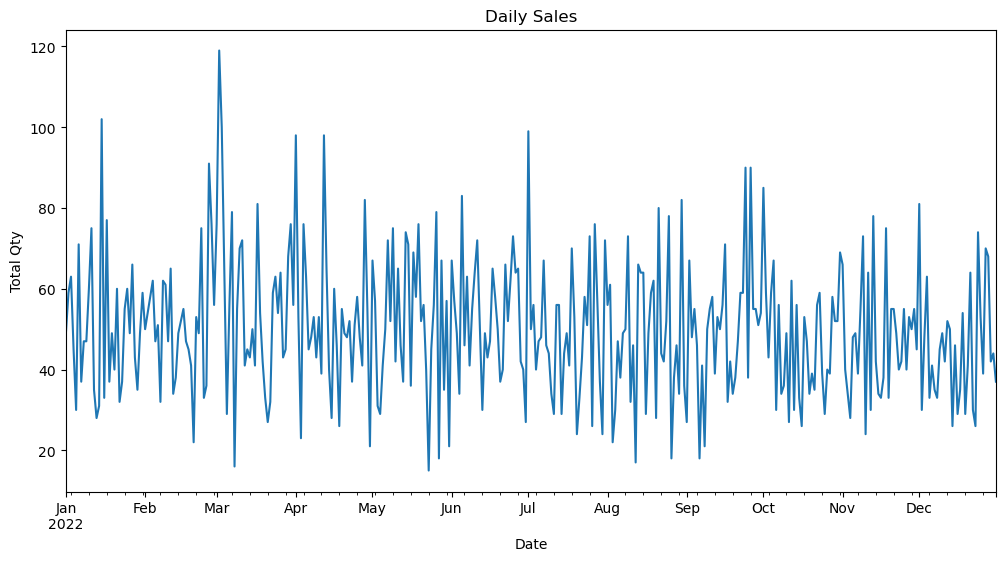

In [22]:
df_reg.plot(figsize=(12, 6),
            title="Daily Sales",
            xlabel="Date",
            ylabel="Total Qty",
            legend=False)

Pembagian data latih (train) dan uji (test)

In [23]:
df_train = df_reg[:int(0.8 * len(df_reg))]
df_test = df_reg[int(0.8 * len(df_reg)):]

Pemodelan Arima

In [24]:
arima_model = pma.auto_arima(
    df_train["Qty"],
    seasonal=False,
    stepwise=False,
    suppress_warnings=True,
    trace=True
)

arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Sat, 28 Oct 2023   AIC                           2504.937
Time:                        09:43:16   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.555      0.000      -1.019      -0.961
sigma2       298.6880     22.254     13.422      0.000     255.071     342.305
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
p, d, q = arima_model.order
model = SARIMAX(df_train["Qty"].values, order=(p, d, q))
model_fit = model.fit()

Root Mean Squared Error

In [26]:
prediction = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1)
rmse = mse(df_test, prediction, squared=False)
rmse

14.153770427924957

#### **Forecasting (Next 90 Days)**

In [27]:
periods = 90
forecasting = model_fit.forecast(steps=periods)
index = pd.date_range(start="01-01-2023", periods=periods)
df_forecast = pd.DataFrame(forecasting, index=index, columns=["Qty"])
df_forecast.describe()

,Qty
count,90.000000
mean,49.725545
std,0.007838
min,49.712195
25%,49.718869
50%,49.725544
75%,49.732221
max,49.738898


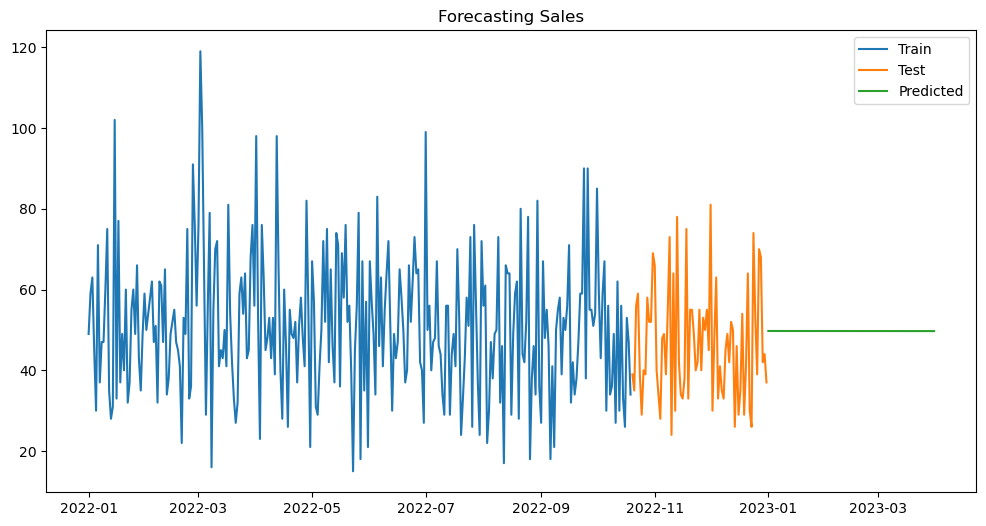

In [28]:
plt.figure(figsize=(12, 6))
plt.title("Forecasting Sales")
plt.plot(df_train, label="Train")
plt.plot(df_test, label="Test")
plt.plot(df_forecast, label="Predicted")
plt.legend(loc="best")
plt.show()

<Axes: title={'center': 'Forecasting Sales'}, xlabel='Date', ylabel='Total Qty'>

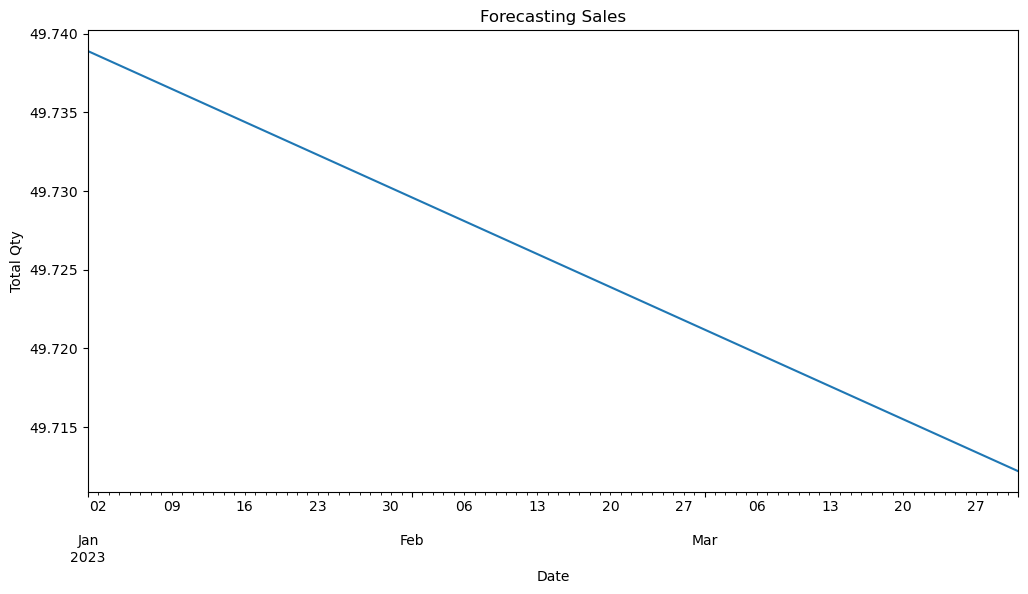

In [29]:
df_forecast.plot(figsize=(12, 6),
                 title="Forecasting Sales",
                 xlabel="Date",
                 ylabel="Total Qty",
                 legend=False)

Product Forecasting - For next 90 days

In [30]:
warnings.filterwarnings("ignore")

df_reg_product = df_merge[["Qty", "Date", "Product Name"]]
df_reg_product = df_reg_product.groupby("Product Name")

df_product_forecast = pd.DataFrame({"Date": pd.date_range(start="2023-01-01", periods=90)})

for product_name, data in df_reg_product:
    target_qty = data["Qty"]
    model = SARIMAX(target_qty.values, order=(p, d, q))
    model_fit = model.fit(disp=False)
    forecasting = model_fit.forecast(90)
    df_product_forecast[product_name] = forecasting

df_product_forecast.set_index("Date", inplace=True)
df_product_forecast.sample(5)

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-20,2.456888,2.962456,5.969319,3.828357,3.514093,4.953567,1.989139,2.797957,3.546593,4.020262
2023-03-25,2.456875,2.962384,5.960200,3.826885,3.514082,4.953560,1.989135,2.797937,3.546370,4.020255
2023-03-18,2.456876,2.962392,5.961197,3.827046,3.514084,4.953560,1.989135,2.797939,3.546394,4.020256
2023-02-12,2.456883,2.962430,5.966040,3.827828,3.514089,4.953565,1.989137,2.797950,3.546513,4.020260
2023-01-05,2.456891,2.962473,5.971458,3.828702,3.514096,4.953569,1.989140,2.797962,3.546646,4.020264


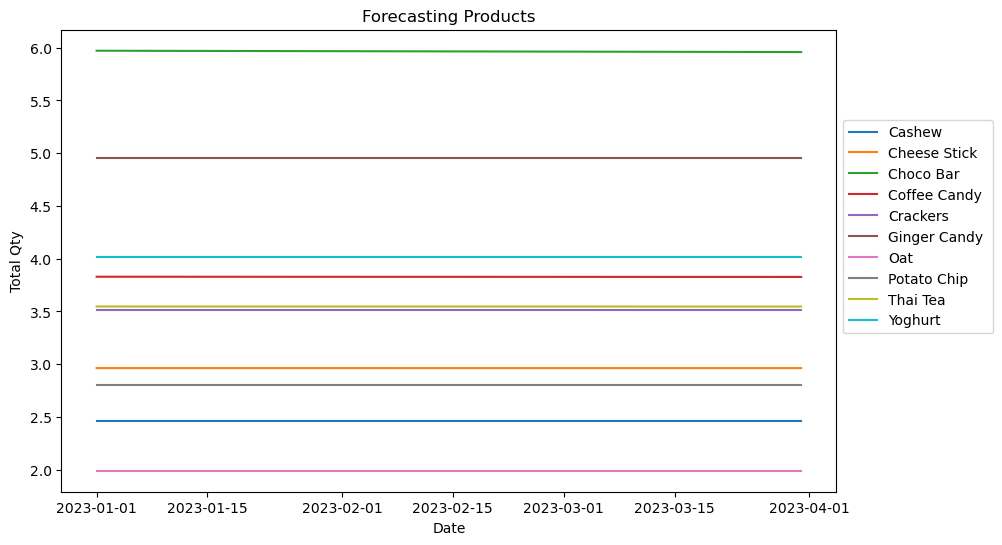

In [31]:
plt.figure(figsize=(10, 6))
for column in df_product_forecast.columns:
    plt.plot(df_product_forecast[column], label=column)

plt.legend(loc="best", bbox_to_anchor=(1, .82))
plt.title("Forecasting Products")
plt.xlabel("Date")
plt.ylabel("Total Qty")
plt.show()